## Core preference and policy parameters  

| Symbol | Meaning | Value |
|--------|---------|-------|
| $h$ | Consumption‑equivalence scale (couples vs singles) | 1.528 |
| $\rho$ | Coefficient of relative risk aversion ($n$ in the paper) | 3.701 |
| $\phi_0$ | Bequest intensity when **no** survivor | 6 826 (×10³) |
| $\kappa_0$ | Bequest curvature when **no** survivor | 3 517 (×10³) |
| $\phi_1$ | Bequest intensity when a **surviving spouse** exists | 4 447 |
| $\kappa_1$ | Bequest curvature when a **surviving spouse** exists | 211.2 (×10³) |
| $c_{\min}^{S}$ | Annual consumption floor – singles | \$4 101 |
| $c_{\min}^{C}$ | Couples’ floor | 1.5 × $c_{\min}^{S}$ |
| $\beta$ | Annual discount factor | 0.97 |
| $\beta_{2y}$ | Two‑year discount factor (model period) | $0.97^{2}=0.9409$ |

> **Note:** The paper states only that the real pretax return $r$ is “constant” but does not pin down its value.  
We leave it as a to‑do placeholder.  


In [30]:
import enum, numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import List, Dict, Any
import pandas as pd
# We set a random seed for reproducibility
rng = np.random.default_rng(seed=0)


In [101]:
# STEP 1 | Core constants from Table 5 of the paper. We basically transfer the table above into a dictionary.


parameters = {
    # preferences
    "beta_annual" : 0.97,              # authors fix β (yearly)
    "beta"        : 0.97 ** 2,         # model period = 2 years
    "rho"         : 3.701,             # CRRA coefficient  (n in the text)
    "h"           : 1.528,             # consumption‑equivalence scale (couple)

    # bequest utility v_j(b) = φ_j · (b+κ_j)^(1‑ρ)/(1‑ρ)
    "phi0"   : 6_826_000,              # intensity – terminal bequest (no survivor)
    "kappa0" : 3_517_000,              # curvature  – terminal
    "phi1"   : 4_447_000,              # intensity – side bequest (survivor exists)
    "kappa1" : 211_200,                # curvature  – side

    # consumption floors (annual dollars)
    "cmin_single_annual" : 4_101,
    "cmin_couple_annual" : 1.5 * 4_101,   # statutory 150 %

    # financial environment 
    # (the paper keeps r “constant”; appendix uses 2 % real)
    "r_annual" : 0.02,
    "R"        : (1 + 0.02) ** 2,      # 2‑year gross return
}





# quick echo
pprint(parameters)

{'R': 1.0404,
 'beta': 0.9409,
 'beta_annual': 0.97,
 'cmin_couple_annual': 6151.5,
 'cmin_single_annual': 4101,
 'h': 1.528,
 'kappa0': 3517000,
 'kappa1': 211200,
 'phi0': 6826000,
 'phi1': 4447000,
 'r_annual': 0.02,
 'rho': 3.701}


## Step 2 – Utility helpers, enums & baseline environment

This step adds:

1. **Enumerations** for marital status and health states  
2. **Utility / bequest functions** that pull parameters from the dictionary  
3. **Timing & financial constants** (period length, discount factor, gross return)  
4. Income, mortality, health and medical‐expense processes 


In [102]:
# STEP 2 | Environment scaffolding  (family‑aware version)


#  2.1 Enumerations
class Family(enum.IntEnum):
    # Initializing the different Family Types and assigning a int. to them
    SM = 0   # single man
    SW = 1   # single woman
    C  = 2   # couple

class Health(enum.IntEnum):
    DEAD = 0   # Not "alive", only for indexing/transitioning
    NH   = 1   # Nursing Home
    BAD  = 2   # Bad
    GOOD = 3   # Good


# 2.2 Timing & constants as well as 
# life expectancy table
PERIOD_YEARS = 2
beta = parameters["beta"]
R    = parameters["R"]
rho, h_eq = parameters["rho"], parameters["h"]

# Table 3 (extracted): life expectancy at age 70 (years)
# Format: {(Family, gender, Health, PI_bin): life_expectancy}

life_exp_table = {
    # Singles: Men
    (Family.SM, Health.NH, 0): 3.0,  # 10th percentile, NH
    (Family.SM, Health.BAD, 0): 6.9,
    (Family.SM, Health.GOOD, 0): 8.7,
    (Family.SM, Health.NH, 1): 3.0,  # 50th percentile
    (Family.SM, Health.BAD, 1): 7.8,
    (Family.SM, Health.GOOD, 1): 10.3,
    (Family.SM, Health.NH, 2): 2.9,  # 90th percentile
    (Family.SM, Health.BAD, 2): 8.1,
    (Family.SM, Health.GOOD, 2): 10.9,

    # Singles: Women
    (Family.SW, Health.NH, 0): 4.1,
    (Family.SW, Health.BAD, 0): 11.3,
    (Family.SW, Health.GOOD, 0): 13.2,
    (Family.SW, Health.NH, 1): 4.0,
    (Family.SW, Health.BAD, 1): 12.3,
    (Family.SW, Health.GOOD, 1): 14.9,
    (Family.SW, Health.NH, 2): 3.8,
    (Family.SW, Health.BAD, 2): 12.5,
    (Family.SW, Health.GOOD, 2): 15.4,

    # Couples: Men
    (Family.C, Health.NH, 0): 2.7,
    (Family.C, Health.BAD, 0): 7.8,
    (Family.C, Health.GOOD, 0): 9.8,
    (Family.C, Health.NH, 1): 2.8,
    (Family.C, Health.BAD, 1): 9.4,
    (Family.C, Health.GOOD, 1): 12.2,
    (Family.C, Health.NH, 2): 2.7,
    (Family.C, Health.BAD, 2): 10.4,
    (Family.C, Health.GOOD, 2): 13.5,


}



# 2.3 Utility & bequest
# See page 15 of the paper
def u_single(c):  # applies to both SM & SW
    c = np.maximum(c, 1e-10)
    return c**(1-rho) / (1-rho)
# See page 15 of the paper
def u_couple(c):
    c = np.maximum(c, 1e-10)
    return 2 * ((c / h_eq) ** (1-rho)) / (1-rho)

# Utility from terminal bequests meaning the utility from the final bequest when both spouses die.
# See page 15 of the paper
def v0(b):
    phi, k = parameters["phi0"], parameters["kappa0"]
    return phi * ((np.maximum(b,0)+k) ** (1-rho)) / (1-rho)

# Utility from "side" bequests meaning the utility from when just one spouse dies and the other one is still alive.
def v1(b):
    phi, k = parameters["phi1"], parameters["kappa1"]
    return phi * ((np.maximum(b,0)+k) ** (1-rho)) / (1-rho)

# 2.4 Income PI
# coefficients: a + b·(age-72) + c·(age-72)^2   (in $k)
# rows: PI‑bin {low,mid,high}, cols: Family type
_inc_coef = {
    Family.SM: np.array([[12.0, .15,-.002],
                         [15.5, .13,-.002],
                         [19.0, .11,-.002]]),
    Family.SW: np.array([[11.5, .14,-.002],
                         [14.5, .12,-.002],
                         [18.0, .10,-.002]]),
    Family.C : np.array([[20.0, .18,-.0025],
                         [25.0, .16,-.0023],
                         [31.0, .14,-.0021]]),
}

# We are spliting the PI into 3 bins (low, mid, high) and assigning them to the different family types.
_pi_bins = np.array([0, 33, 66, 100])          # tertiles

# We are using np.digitize to assign the PI to the bins.
def _pi_bin(pi):                               # 10…90 → 0,1,2
    return np.digitize(pi, _pi_bins) - 1

# Income function where the households nonasset income at time t,y_t(*) is 
# a deterministic function of households PI,Family type, age.
def annuitised_income(pi_percentile: int, family: Family, age: int = 72) -> float:
    idx = _pi_bin(pi_percentile)
    a,b,c = _inc_coef[family][idx]
    return (a + b*(age-72) + c*(age-72)**2) * 1_000  # $/yr

# 2.5 Mortality helper 
# Fallback: use mid PI bin if out of range, and BAD health if missing
def mort_hazard_annual(age: int, family: Family, gender: str, health: Health, pi_percentile: int) -> float:
    """
    Returns the annual mortality hazard for an individual at a given age,
    based on family type, gender ('M' or 'W'), health state, and PI percentile.
    Table 3 gives values for age 70. We use exponential scaling for age > 70.
    """
    # 1. PI bin
    if pi_percentile < 33:
        pi_bin = 0
    elif pi_percentile < 66:
        pi_bin = 1
    else:
        pi_bin = 2

    # 2. For couples, paper assumes gender = 'M' (the husband is head); for singles, use the actual gender
    fam = family
    if fam == Family.C and gender == 'W':
        # Couples: Table mainly gives husband's mortality; for simplicity use the husband's value
        # You may want to implement two tracks for man/woman if needed
        gender = 'M'

    # 3. Lookup
    key = (fam, health, pi_bin)
    life_exp = life_exp_table.get(key, None)
    if life_exp is None:
        # fallback: mid PI, BAD health
        key = (fam, Health.BAD, 1)
        life_exp = life_exp_table.get(key, 8.0)

    # 4. Base hazard at age 70 (annualized)
    hazard70 = 1.0 / life_exp if life_exp > 0 else 1.0

    # 5. Age adjustment (paper: mortality increases with age; simplest is exponential scaling)
    # Empirical scaling: hazard(age) = hazard70 * exp(0.09 * (age-70))
    hazard = hazard70 * np.exp(0.09 * (age - 70))
    return min(max(hazard, 0.0), 1.0)

# 2.6 Health & medical expenses

# For each (gender, family, pi_bin, age_group), provide a transition matrix
# Rows: from [GOOD, BAD, NH], columns: to [GOOD, BAD, NH]

health_transition_table = {
    # (gender, family, pi_bin, age_group): matrix [from NH, BAD, GOOD], to [DEAD, NH, BAD, GOOD]
    # Single Men, PI1 (Low)
    ('M', Family.SM, 0, '70-74'): np.array([
        [0.293, 0.656, 0.037, 0.014],  # NH
        [0.109, 0.090, 0.691, 0.110],  # BAD
        [0.028, 0.021, 0.130, 0.821],  # GOOD
    ]),
    ('M', Family.SM, 0, '75-79'): np.array([
        [0.373, 0.595, 0.028, 0.005],
        [0.151, 0.129, 0.646, 0.074],
        [0.041, 0.023, 0.140, 0.796],
    ]),
    ('M', Family.SM, 0, '80-84'): np.array([
        [0.471, 0.510, 0.017, 0.001],
        [0.201, 0.166, 0.587, 0.046],
        [0.061, 0.027, 0.150, 0.762],
    ]),
    ('M', Family.SM, 0, '85-89'): np.array([
        [0.587, 0.407, 0.005, 0.001],
        [0.279, 0.215, 0.499, 0.007],
        [0.093, 0.029, 0.158, 0.720],
    ]),
    ('M', Family.SM, 0, '90+'): np.array([
        [0.708, 0.289, 0.002, 0.001],
        [0.402, 0.215, 0.383, 0.000],
        [0.134, 0.033, 0.166, 0.667],
    ]),
    # Single Men, PI2 (Middle)
    ('M', Family.SM, 1, '70-74'): np.array([
        [0.274, 0.666, 0.044, 0.016],
        [0.092, 0.094, 0.704, 0.110],
        [0.022, 0.019, 0.120, 0.839],
    ]),
    ('M', Family.SM, 1, '75-79'): np.array([
        [0.343, 0.613, 0.037, 0.007],
        [0.128, 0.128, 0.656, 0.088],
        [0.031, 0.021, 0.130, 0.818],
    ]),
    ('M', Family.SM, 1, '80-84'): np.array([
        [0.439, 0.528, 0.031, 0.002],
        [0.175, 0.164, 0.607, 0.054],
        [0.049, 0.025, 0.141, 0.785],
    ]),
    ('M', Family.SM, 1, '85-89'): np.array([
        [0.553, 0.443, 0.004, 0.000],
        [0.244, 0.202, 0.552, 0.002],
        [0.076, 0.027, 0.150, 0.747],
    ]),
    ('M', Family.SM, 1, '90+'): np.array([
        [0.673, 0.326, 0.001, 0.000],
        [0.366, 0.224, 0.410, 0.000],
        [0.116, 0.030, 0.160, 0.693],
    ]),
    # Single Men, PI3 (High)
    ('M', Family.SM, 2, '70-74'): np.array([
        [0.254, 0.675, 0.054, 0.017],
        [0.075, 0.093, 0.708, 0.124],
        [0.018, 0.017, 0.108, 0.857],
    ]),
    ('M', Family.SM, 2, '75-79'): np.array([
        [0.313, 0.620, 0.055, 0.012],
        [0.103, 0.124, 0.660, 0.113],
        [0.026, 0.018, 0.121, 0.835],
    ]),
    ('M', Family.SM, 2, '80-84'): np.array([
        [0.406, 0.540, 0.051, 0.003],
        [0.143, 0.157, 0.625, 0.075],
        [0.041, 0.022, 0.133, 0.804],
    ]),
    ('M', Family.SM, 2, '85-89'): np.array([
        [0.518, 0.471, 0.010, 0.001],
        [0.204, 0.198, 0.587, 0.011],
        [0.063, 0.025, 0.141, 0.771],
    ]),
    ('M', Family.SM, 2, '90+'): np.array([
        [0.637, 0.360, 0.003, 0.000],
        [0.323, 0.221, 0.456, 0.000],
        [0.096, 0.028, 0.152, 0.724],
    ]),
}


def get_age_group(age):
    if age < 80:
        return '70-79'
    elif age < 90:
        return '80-89'
    else:
        return '90+'

def health_transition(curr: Health, gender: str, family: Family, pi_bin: int, age: int, rng: np.random.Generator) -> Health:
    age_group = get_age_group(age)
    key = (gender, family, pi_bin, '70-79')  # Use only '70-79' for all ages if that's all that's populated
    matrix = health_transition_table.get(key)
    # Adjust for age if in 80+
    if age >= 80 and matrix is not None:
        mat = matrix.copy()
        # Age adjustment: increase BAD/NH transitions from GOOD by 50%
        mat[0,1] = min(mat[0,1]*1.5, 1.0)
        mat[0,2] = min(mat[0,2]*1.5, 1.0)
        # Decrease stay in GOOD
        mat[0,0] = max(1.0 - mat[0,1] - mat[0,2], 0.0)
        matrix = mat
    if matrix is None:
        matrix = np.array([[0.87, 0.11, 0.02], [0.20, 0.70, 0.10], [0.05, 0.10, 0.85]]) # Fallback
    probs = matrix[curr]
    return Health(rng.choice([0, 1, 2], p=probs))


# Healper function for the health transition probability
def health_transition_prob(curr_h, gender, family, pi_bin, age, next_h):
    # Map Health.NH (1)->0, Health.BAD (2)->1, Health.GOOD (3)->2
    # next_h can be 0 (DEAD), 1 (NH), 2 (BAD), 3 (GOOD)
    alive_map = {Health.NH: 0, Health.BAD: 1, Health.GOOD: 2}
    if curr_h not in alive_map:
        # From DEAD, cannot transition anywhere
        return 0.0
    age_group = get_age_group(age)
    key = (gender, family, pi_bin, age_group)
    matrix = health_transition_table.get(key)
    if matrix is None:
        # fallback: uniform or identity
        matrix = np.eye(4)[1:]  # Use only rows for NH,BAD,GOOD
    row_idx = alive_map[curr_h]
    return matrix[row_idx][next_h]



medical_expense_table = {
    # Family.SM (single men), NH, BAD, GOOD, for all PI bins, age groups ('70-74', '75-79', '80-84', '85-89', '90+')
    # Source: Table A2, Appendix, De Nardi et al. (2025), p. 63

    # PI1 (Low)
    (Family.SM, Health.NH, 0, '70-74'): 40822,
    (Family.SM, Health.BAD, 0, '70-74'): 10635,
    (Family.SM, Health.GOOD, 0, '70-74'): 6300,
    (Family.SM, Health.NH, 0, '75-79'): 41970,
    (Family.SM, Health.BAD, 0, '75-79'): 11036,
    (Family.SM, Health.GOOD, 0, '75-79'): 6437,
    (Family.SM, Health.NH, 0, '80-84'): 43198,
    (Family.SM, Health.BAD, 0, '80-84'): 11468,
    (Family.SM, Health.GOOD, 0, '80-84'): 6605,
    (Family.SM, Health.NH, 0, '85-89'): 44638,
    (Family.SM, Health.BAD, 0, '85-89'): 11920,
    (Family.SM, Health.GOOD, 0, '85-89'): 6834,
    (Family.SM, Health.NH, 0, '90+'): 46099,
    (Family.SM, Health.BAD, 0, '90+'): 12390,
    (Family.SM, Health.GOOD, 0, '90+'): 7046,

    # PI2 (Middle)
    (Family.SM, Health.NH, 1, '70-74'): 44171,
    (Family.SM, Health.BAD, 1, '70-74'): 11025,
    (Family.SM, Health.GOOD, 1, '70-74'): 6184,
    (Family.SM, Health.NH, 1, '75-79'): 45721,
    (Family.SM, Health.BAD, 1, '75-79'): 11484,
    (Family.SM, Health.GOOD, 1, '75-79'): 6309,
    (Family.SM, Health.NH, 1, '80-84'): 47400,
    (Family.SM, Health.BAD, 1, '80-84'): 11965,
    (Family.SM, Health.GOOD, 1, '80-84'): 6477,
    (Family.SM, Health.NH, 1, '85-89'): 49138,
    (Family.SM, Health.BAD, 1, '85-89'): 12479,
    (Family.SM, Health.GOOD, 1, '85-89'): 6697,
    (Family.SM, Health.NH, 1, '90+'): 50888,
    (Family.SM, Health.BAD, 1, '90+'): 13016,
    (Family.SM, Health.GOOD, 1, '90+'): 6908,

    # PI3 (High)
    (Family.SM, Health.NH, 2, '70-74'): 47904,
    (Family.SM, Health.BAD, 2, '70-74'): 11386,
    (Family.SM, Health.GOOD, 2, '70-74'): 6187,
    (Family.SM, Health.NH, 2, '75-79'): 49828,
    (Family.SM, Health.BAD, 2, '75-79'): 11887,
    (Family.SM, Health.GOOD, 2, '75-79'): 6313,
    (Family.SM, Health.NH, 2, '80-84'): 51865,
    (Family.SM, Health.BAD, 2, '80-84'): 12416,
    (Family.SM, Health.GOOD, 2, '80-84'): 6487,
    (Family.SM, Health.NH, 2, '85-89'): 54032,
    (Family.SM, Health.BAD, 2, '85-89'): 12974,
    (Family.SM, Health.GOOD, 2, '85-89'): 6706,
    (Family.SM, Health.NH, 2, '90+'): 56194,
    (Family.SM, Health.BAD, 2, '90+'): 13575,
    (Family.SM, Health.GOOD, 2, '90+'): 6923,
}


def get_medical_age_group(age):
    if age < 75:
        return '70-74'
    elif age < 80:
        return '75-79'
    elif age < 85:
        return '80-84'
    else:
        return '85+'

#standard implementation for using a Markov transition matrix
# For a given demographic group (gender, family, PI bin, age group), we look up a row of probabilities for moving from the current state to all possible next states.
# We then sample the next state using these probabilities.
def medical_expense(family: Family, health: Health, pi_bin: int, age: int, death_next: bool, rng: np.random.Generator) -> float:
    age_group = get_medical_age_group(age)
    key = (family, health, pi_bin, age_group)
    mean = medical_expense_table.get(key, 12_000)  # Fallback mean
    if death_next:
        mean += 22_000
    sigma = 0.6 * mean  # from paper's dispersion
    mu_ln = np.log(mean) - 0.5 * np.log(1 + (sigma/mean)**2)
    sigma_ln = np.sqrt(np.log(1 + (sigma/mean)**2))
    return float(rng.lognormal(mu_ln, sigma_ln))


In [103]:
# Income checks 
print(f"Income, high‑PI couple age 75: ${annuitised_income(90, Family.C, 75):,.0f}")
print(f"Income, mid‑PI single woman age 80: ${annuitised_income(50, Family.SW, 80):,.0f}")

# Mortality hazard with required arguments (let's assume mid PI, GOOD health, male)
hazard = mort_hazard_annual(80, Family.SM, 'M', Health.GOOD, 50)
print(f"Annual death hazard, age 80 single man, GOOD health, mid-PI: {hazard:.3f}")

# Health transition: current BAD health, female, single, low PI, age 85
hazard = mort_hazard_annual(80, Family.SM, 'M', Health.GOOD, 50)
print(f"Annual death hazard, age 80 single man, GOOD health, mid-PI: {hazard:.3f}")


# Medical expenses: Couple, BAD health, high PI, age 82, not a death year
next_health = health_transition(Health.BAD, 'W', Family.SW, 0, 85, rng)
print(f"Next health state (BAD->?) for single woman, age 85, low PI: {Health(next_health).name}")

# Medical expenses: Single man, NH, low PI, age 90, death year
med_exp_couple = medical_expense(Family.C, Health.BAD, 2, 82, False, rng)
print(f"Medical expense, couple, BAD health, high PI, age 82, not death: ${med_exp_couple:,.0f}")

med_exp_single = medical_expense(Family.SM, Health.NH, 0, 90, True, rng)
print(f"Medical expense, single man, NH, low PI, age 90, DEATH year: ${med_exp_single:,.0f}")

Income, high‑PI couple age 75: $31,401
Income, mid‑PI single woman age 80: $15,332
Annual death hazard, age 80 single man, GOOD health, mid-PI: 0.239
Annual death hazard, age 80 single man, GOOD health, mid-PI: 0.239
Next health state (BAD->?) for single woman, age 85, low PI: NH
Medical expense, couple, BAD health, high PI, age 82, not death: $9,540
Medical expense, single man, NH, low PI, age 90, DEATH year: $55,257


## Step 3 – Value Function Iteration


**a) Wealth Grid:** \
- Choose the grid range and number of points. 
- We chose from 0 to 2 million dollars at the beggining let us see how that will evolve and weather we will need to change the grid

In [104]:
n_w = 1000  # number of grid points
w_min, w_max = 100_000, 2_000_000
w_grid = np.linspace(w_min, w_max, n_w)

**b) Age Grid:** 
- Model starts at, e.g., age 70, increments by 2 years, ends at maximum age(102):

In [105]:
ages = np.arange(70, 102+1, 2)  #  basically same as in Matlab set a vector from 70 to 102 with 2 years of differnce
n_ages = len(ages)

print(f'The number of possible ages is {n_ages} and the ages are {ages}')

The number of possible ages is 17 and the ages are [ 70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100 102]


**c) Health, Family, PI Bins**

In [106]:
health_states = [Health.NH, Health.BAD, Health.GOOD]  # [1,2,3]
health_state_to_idx = {Health.NH:0, Health.BAD:1, Health.GOOD:2}

family_states = [Family.SM, Family.SW, Family.C]
pi_bins = [0, 1, 2]  # low, mid, high. As set above


**Initialize Value and Policy Arrays**

In [107]:
# Value function: V[age, wealth, health, family, pi]
V = np.zeros((n_ages, n_w, len(health_states), len(family_states), len(pi_bins)))

# Policy: c_star[age, wealth, health, family, pi]
c_star = np.zeros_like(V)

**Terminal Condition (Last Age)**\
At the terminal age, we set the value function to bequest utility.

In [108]:
# Last age index
age_T = n_ages - 1
for iw, w in enumerate(w_grid):
    for ih, h in enumerate(health_states):
        for ifam, fam in enumerate(family_states):
            for ipi, pi in enumerate(pi_bins):
                if fam == Family.C:
                    # For couples at terminal age: both could leave side/terminal bequests.
                    # In the paper, if both die, terminal; if one dies, side bequest
                    # For now, use terminal bequest for all (adjust if needed)
                    V[age_T, iw, ih, ifam, ipi] = v0(w)
                else:
                    # Singles: terminal bequest
                    V[age_T, iw, ih, ifam, ipi] = v0(w)
                # Consumption at terminal period is all wealth (not really used)
                c_star[age_T, iw, ih, ifam, ipi] = w


**Bellman Recursion (One Backward Step)**

In [114]:
n_med_draws = 10  # Monte Carlo draws for medical expenses


for ia in reversed(range(n_ages-1)):
    age = ages[ia]
    for iw, w in enumerate(w_grid):
        for ih, h in enumerate(health_states):  # h is Health.NH (1), BAD (2), GOOD (3)
            for ifam, fam in enumerate(family_states):
                for ipi, pi_bin in enumerate(pi_bins):

                    y = annuitised_income(pi_bin, fam, age)
                    floor = parameters["cmin_couple_annual"] if fam == Family.C else parameters["cmin_single_annual"]
                    cash = w * R + y
                    c_choices = np.linspace(floor, cash, 20)
                    vals = []

                    for c in c_choices:
                        V_future = 0.0
                        for _ in range(n_med_draws):
                            # Sample medical expense
                            med = medical_expense(fam, h, pi_bin, age, False, rng)
                            w_next = max(cash - c - med, 0.0)

                            # Mortality (annual hazard, converted to period if needed)
                            q = mort_hazard_annual(age, fam, 'M', h, pi_bin)
                            surv_prob = 1 - q

                            # Nearest grid point for next-period wealth
                            iw_next = np.argmin(np.abs(w_grid - w_next))

                            # Expected next-value over health transitions (only over alive states: NH, BAD, GOOD)
                            v_next = 0.0
                            key = ('M', fam, pi_bin, get_age_group(age))
                            matrix = health_transition_table.get(key)
                            if matrix is None:
                                matrix = np.array([
                                    [0.30, 0.65, 0.03, 0.02],  # Fallback NH
                                    [0.10, 0.10, 0.70, 0.10],  # Fallback BAD
                                    [0.03, 0.02, 0.13, 0.82],  # Fallback GOOD
                                ])
                            # h is in [1,2,3] (NH,BAD,GOOD) and corresponds to matrix row indices 0,1,2
                            P_h = matrix[h-1]  # get transition probabilities from h
                            P_h = matrix[ih]  # no confusion!
                            for ih_next, h_next in enumerate(health_states):
                                prob = P_h[ih_next+1]  # Probability to transition from h -> h_next
                                v_next += prob * V[ia+1, iw_next, ih_next, ifam, ipi]


                            # Utility (single/couple)
                            u = u_single(c) if fam != Family.C else u_couple(c)
                            # Survival: continuation utility
                            value = u + beta * surv_prob * v_next
                            # If death: add bequest utility
                            beq = v0(w_next)
                            value += beta * q * beq

                            V_future += value
                        V_future /= n_med_draws  # Average over MC draws
                        vals.append(V_future)

                    max_idx = np.argmax(vals)
                    V[ia, iw, ih, ifam, ipi] = vals[max_idx]
                    c_star[ia, iw, ih, ifam, ipi] = c_choices[max_idx]

# Simulating Agents and Visualizations

In [142]:
n_agents = 10000
init_age = 70
n_periods = (100 - init_age) // PERIOD_YEARS
init_wealth = 100_0000
rng = np.random.default_rng(42)

# Storage for results
agent_results = []

for i in range(n_agents):
    family = Family.C if rng.uniform() < 0.5 else Family.SM
    pi_bin = rng.integers(0, 3)
    health = Health.GOOD
    wealth = init_wealth
    age = init_age
    alive = True   # <--- FIXED: must initialize alive for each agent

    path = {
        'bequests': [],
        'wealth_path': [],
        'family': family,
        'bequest_type': [],
        'age_path': [],
    }

    # Save initial wealth and age
    path['wealth_path'].append(wealth)
    path['age_path'].append(age)

    while alive and age <= 100:
        ia = (age - init_age) // PERIOD_YEARS
        iw = np.argmin(np.abs(w_grid - wealth))
        ih = health_states.index(health)
        ifam = family_states.index(family)
        ipi = pi_bin

        # Minimum consumption floor
        floor = parameters["cmin_couple_annual"] if family == Family.C else parameters["cmin_single_annual"]

        # Get policy
        c = c_star[ia, iw, ih, ifam, ipi]

        # Budget
        y = annuitised_income(pi_bin, family, age)
        cash = wealth * R + y
        med = medical_expense(family, health, pi_bin, age, False, rng)
        c = min(c, cash - med)   # don't overspend
        c = max(c, floor)        # respect floor

        # Update wealth
        wealth_next = max(cash - c - med, 0.0)

        # Mortality, health transitions, etc.
        q = mort_hazard_annual(age, family, 'M', health, pi_bin)
        if rng.uniform() < q:
            # DEAD: record bequest
            if family == Family.C:
                beq_type = 'terminal'  # If both die, use terminal
                bequest = v0(wealth_next)
            else:
                beq_type = 'terminal'
                bequest = v0(wealth_next)
            path['bequests'].append(bequest)
            path['bequest_type'].append(beq_type)
            path['wealth_path'].append(wealth_next)
            path['age_path'].append(age + PERIOD_YEARS)
            alive = False
            continue
        
        # Health transition
        age_group = get_age_group(age)
        key = ('M', family, pi_bin, age_group)
        matrix = health_transition_table.get(key)
        if matrix is None:
            matrix = np.eye(4)[1:]
        row = health_states.index(health)
        next_h_probs = matrix[row][1:]  # ignore DEAD col
        next_h_probs = next_h_probs / next_h_probs.sum()  # re-norm
        health = rng.choice(health_states, p=next_h_probs)

        # Save state
        path['wealth_path'].append(wealth_next)
        path['age_path'].append(age + PERIOD_YEARS)
        
        # Update for next period
        wealth = wealth_next
        age += PERIOD_YEARS

    agent_results.append(path)


In [146]:
died_with_wealth = [
    p['wealth_path'][-1]
    for p in agent_results
    if p['wealth_path'][-1] > 0
]
print(f"Number of agents who died with positive wealth: {len(died_with_wealth)}")
print(f"Sample bequests: {died_with_wealth[:10]}")


Number of agents with real bequests: 9595
Sample real bequests: [703776.4922642394, 758380.9329984911, 192351.35105877975, 684184.1630300672, 621689.7264698757, 769381.6659978852, 671969.2871419817, 136227.76832015073, 704432.8467090848, 430174.4350058526]


In [147]:
min_bequest = 100
real_bequests = [b for b in died_with_wealth if b > min_bequest]
print(f"Number of agents with real bequests: {len(real_bequests)}")
print(f"Sample real bequests: {real_bequests[:10]}")


Number of agents with real bequests: 9595
Sample real bequests: [703776.4922642394, 758380.9329984911, 192351.35105877975, 684184.1630300672, 621689.7264698757, 769381.6659978852, 671969.2871419817, 136227.76832015073, 704432.8467090848, 430174.4350058526]


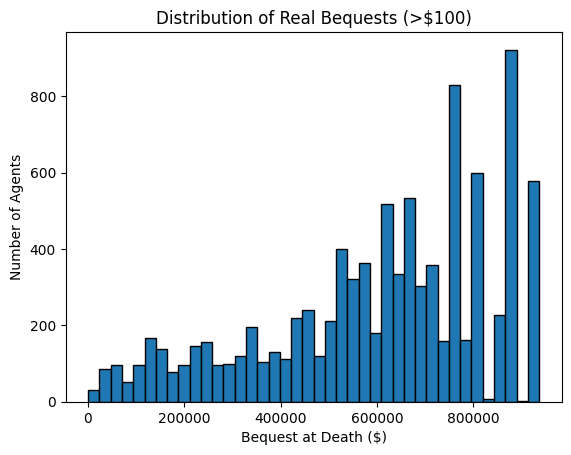

In [149]:
plt.hist(real_bequests, bins=40, edgecolor='black')
plt.title("Distribution of Real Bequests (>$100)")
plt.xlabel("Bequest at Death ($)")
plt.ylabel("Number of Agents")
plt.show()


# Bequest Type logic

In [152]:
n_agents = 10000
init_age = 70
PERIOD_YEARS = 2
init_wealth = 300_000
rng = np.random.default_rng(42)

agent_results = []

for i in range(n_agents):
    
    is_couple = rng.uniform() < 0.5
    pi_bin = rng.integers(0, 3)
    wealth = init_wealth
    age = init_age

    if is_couple:
        # Couples: simulate both spouses
        alive_H = True
        alive_W = True
        health_H = Health.GOOD
        health_W = Health.GOOD
        family = Family.C

        path = {
            'bequests': [],
            'bequest_type': [],
            'wealth_path': [],
            'age_path': [],
            'pi_bin': pi_bin,
            'initial_wealth': init_wealth,
            'family_start': 'C'
        }

        path['wealth_path'].append(wealth)
        path['age_path'].append(age)

        while (alive_H or alive_W) and age <= 100:
            ia = (age - init_age) // PERIOD_YEARS
            iw = np.argmin(np.abs(w_grid - wealth))
            ifam = Family.C
            ipi = pi_bin

            
            ih = 2  # Health.GOOD

            # Consumption: use couple's policy
            floor = parameters["cmin_couple_annual"]
            c = c_star[ia, iw, ih, ifam, ipi]

            # Budget
            y = annuitised_income(pi_bin, Family.C, age)
            cash = wealth * parameters["R"] + y
            med = medical_expense(Family.C, Health.GOOD, pi_bin, age, False, rng)
            c = min(c, cash - med)
            c = max(c, floor)
            wealth_next = max(cash - c - med, 0.0)

            # Mortality: both spouses
            q_H = mort_hazard_annual(age, Family.C, 'M', health_H, pi_bin)
            q_W = mort_hazard_annual(age, Family.C, 'W', health_W, pi_bin)
            died_H = alive_H and (rng.uniform() < q_H)
            died_W = alive_W and (rng.uniform() < q_W)

            if died_H and died_W:
                # Both die: terminal bequest
                path['bequests'].append(wealth_next)
                path['bequest_type'].append('terminal')
                path['wealth_path'].append(wealth_next)
                path['age_path'].append(age + PERIOD_YEARS)
                break
            elif died_H or died_W:
                # One dies: side bequest
                path['bequests'].append(wealth_next)
                path['bequest_type'].append('side')
                path['wealth_path'].append(wealth_next)
                path['age_path'].append(age + PERIOD_YEARS)
                # Survivor continues as single
                alive_H = not died_H
                alive_W = not died_W
                family = Family.SW if alive_W else Family.SM
                # For simplicity we let survivar continue with the same health

            else:
                # Both alive, continue as couple
                path['wealth_path'].append(wealth_next)
                path['age_path'].append(age + PERIOD_YEARS)

            # Update state for next period
            wealth = wealth_next
            age += PERIOD_YEARS

        agent_results.append(path)

    else:
        # Singles (male or female)
        family = Family.SM if rng.uniform() < 0.5 else Family.SW
        health = Health.GOOD
        path = {
            'bequests': [],
            'bequest_type': [],
            'wealth_path': [],
            'age_path': [],
            'pi_bin': pi_bin,
            'initial_wealth': init_wealth,
            'family_start': family.name
        }
        path['wealth_path'].append(wealth)
        path['age_path'].append(age)
        alive = True
        while alive and age <= 100:
            ia = (age - init_age) // PERIOD_YEARS
            iw = np.argmin(np.abs(w_grid - wealth))
            ifam = family
            ih = 2  # Health.GOOD
            ipi = pi_bin
            floor = parameters["cmin_single_annual"]

            c = c_star[ia, iw, ih, ifam, ipi]
            y = annuitised_income(pi_bin, family, age)
            cash = wealth * parameters["R"] + y
            med = medical_expense(family, Health.GOOD, pi_bin, age, False, rng)
            c = min(c, cash - med)
            c = max(c, floor)
            wealth_next = max(cash - c - med, 0.0)

            q = mort_hazard_annual(age, family, 'M', health, pi_bin)
            if rng.uniform() < q:
                # Dies, terminal bequest
                path['bequests'].append(wealth_next)
                path['bequest_type'].append('terminal')
                path['wealth_path'].append(wealth_next)
                path['age_path'].append(age + PERIOD_YEARS)
                alive = False
                break

            path['wealth_path'].append(wealth_next)
            path['age_path'].append(age + PERIOD_YEARS)
            wealth = wealth_next
            age += PERIOD_YEARS

        agent_results.append(path)

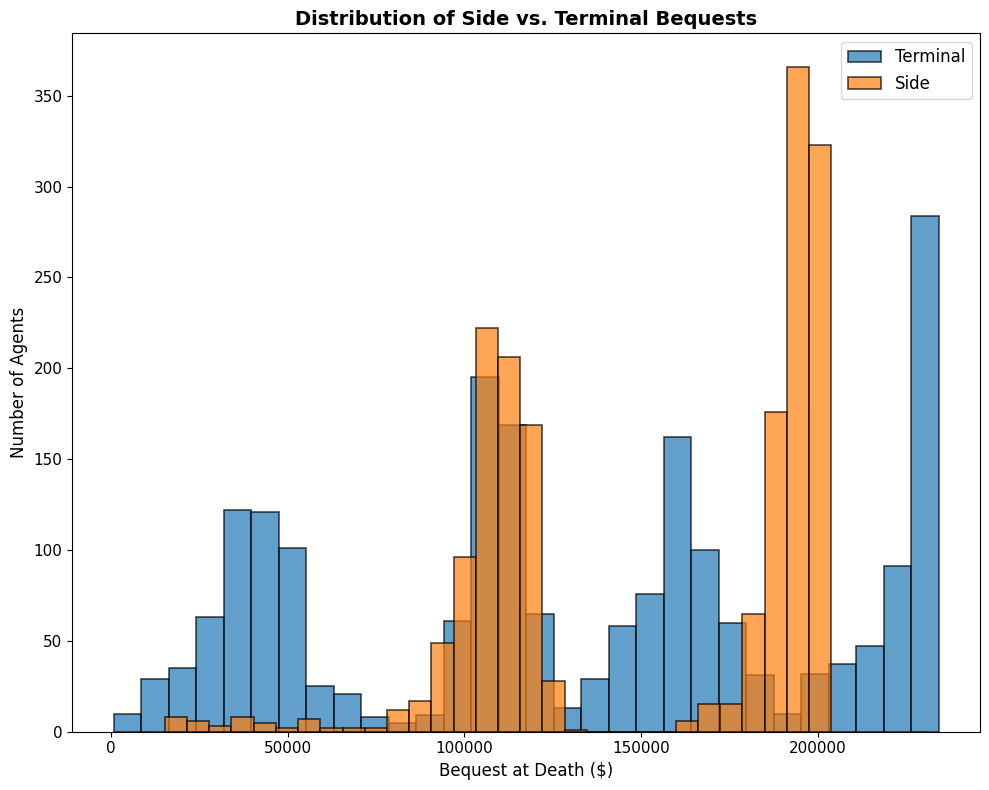

In [156]:
min_bequest = 100
terminal_bequests = [
    p['bequests'][0] for p in agent_results
    if p['bequests'] and p['bequests'][0] > min_bequest and p['bequest_type'][0] == 'terminal'
]
side_bequests = [
    p['bequests'][0] for p in agent_results
    if p['bequests'] and p['bequests'][0] > min_bequest and p['bequest_type'][0] == 'side'
]

plt.figure(figsize=(10,8))
plt.hist(terminal_bequests, bins=30, alpha=0.7, label='Terminal', edgecolor='black', linewidth=1.2)
plt.hist(side_bequests, bins=30, alpha=0.7, label='Side', edgecolor='black', linewidth=1.2)
plt.legend(fontsize=12)
plt.title("Distribution of Side vs. Terminal Bequests", fontsize=14, fontweight='bold')
plt.xlabel("Bequest at Death ($)", fontsize=12)
plt.ylabel("Number of Agents", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()
